In [83]:
using Pkg
using Markdown, Revise
using FourierTools
using NDTools, Plots, View5D, ImageShow
using PSFs

In [293]:
function show_xyz(args...; z_offset=0, gamma=nothing, bg=0.12, dx=5, dy=5)
    dat = []
    sizes = size.(args)
    mdim = maximum(length.(sizes))
    max_size = Tuple(ones(Int, 4))
    for s in sizes
        max_size = max.(max_size,expand_size(s,max_size))
    end
    @show max_size
    if isnothing(gamma)
        gamma= (eltype(args[1]) <: Complex) ? 0.6 : 0.4
    end
    canvas = bg .* ones(length(args)*(max_size[2]+dy), 2*max_size[4]*(max_size[1]+dx))
    n=0
    for data in args
        n=n+1
        data = expand_dims(data,Val(4))
        scale = inv(maximum(abs.((data))))
        double = (size(data,3)>1) ? 2 : 1
        for el in 1:size(data,4)
            midz = size(data,3)÷2+1+z_offset
            midy = size(data,2)÷2+1+z_offset
            src = (scale.*(abs.(data[:,:,midz,el]))').^gamma
            select_region!(src, canvas, dst_center=ceil.(Int, ((n-0.5)*(max_size[2]+dy), ((el-1)+0.5)*(max_size[1]+dx))))
            if double > 1
                src = (scale.*(abs.(data[:,midy,:,el]))').^gamma
                select_region!(src, canvas, dst_center=ceil.(Int, ((n-0.5)*(max_size[2]+dy), (max_size[4]+(el-1)+0.5)*(max_size[1]+dx))))
            end
        end
    end
    myim = Gray.(canvas)
    return myim
end

show_xyz (generic function with 1 method)

# Simulate a first simple PSF

- prepare the required parameters
- simulate the widefield PSF
- display the result

## required parameters: Wavelength, NA, n, size, sampling

In [276]:
λ_em = 0.5; NA = 1.4; n = 1.52
λ_ex = 0.488 # only needed for some PSFs, such as confocal, ISM or TwoPhoton
pp = PSFParams(λ_em, NA, n; pol=pol_x)
sz = (256, 256, 256)
sampling = (0.050,0.050,0.050)
print(pp)

PSFParams(0.5, 1.4, 1.52, Float32, ModeWidefield, PSFs.pol_x, PSFs.var"#3#4"(), MethodRichardsWolf, nothing, Aberrations(Any[], Any[], :OSA), nothing, nothing, nothing)

## Simulate Widefield PSF

In [283]:
p = psf(sz, pp; sampling=sampling);

# Display Data

max_size = (256, 256, 256, 1)


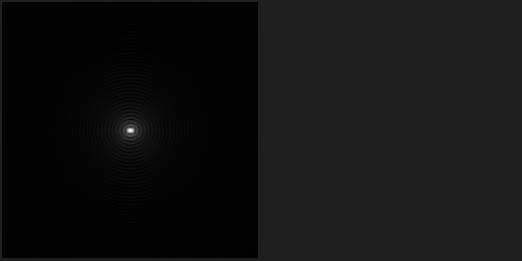

In [294]:
show_xyz(p)

Widefield PSF XY, XZ

# The Details:
# Step One: Pupil Ex and Ey (complex) Amplitudes

max_size = (256, 256, 1, 2)


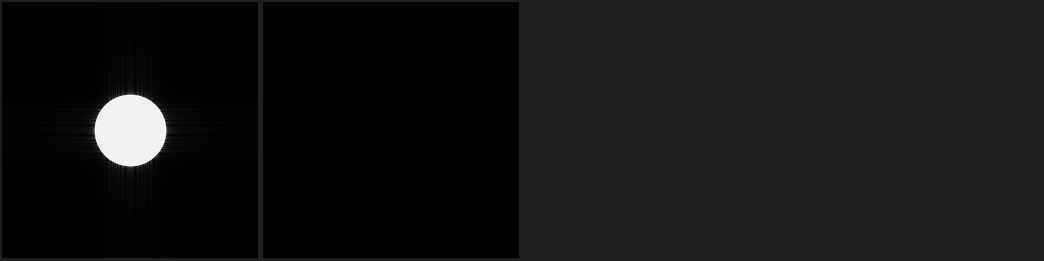

In [289]:
my_pupil = PSFs.field_pupil(sz, pp, sampling) .* get_pupil_aperture(sz,pp,sampling)
show_xyz(my_pupil)

# Step Two: Reference Sphere Ex, Ey, Ez Amplitudes

max_size = (256, 256, 256, 3)


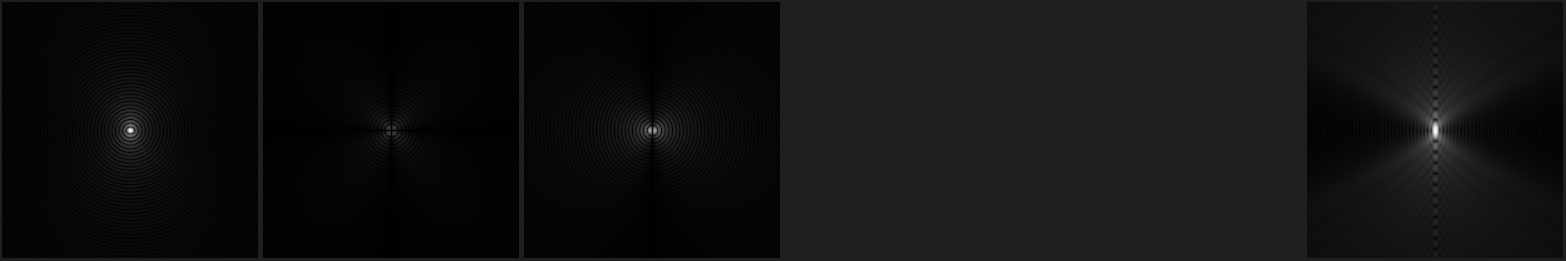

In [290]:
pp = PSFParams(0.5, 1.4, 1.52; pol=pol_x)
pa = apsf(sz, pp; sampling=sampling)
show_xyz(pa)

# Step Three: Propagation

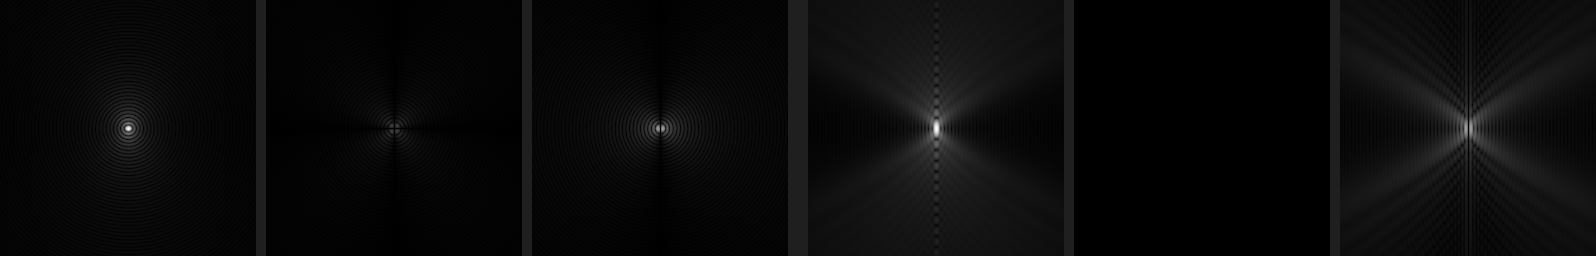

In [153]:
pa = apsf(sz, pp; sampling=sampling)
show_xyz(pa)

X, Y Z  Electric field amplitudexs. Left: XY-Plane, Right: XZ-Plane

# The Aplanatic Factor
Accounting for the angular dependence of an aplanatic objective following Abbe's sine condition.

Energy distributes similarly to the seasons on earth.
+ sqrt.(cos(theta))     for excitation
+ 1./sqrt.(cos(theta))  for emission

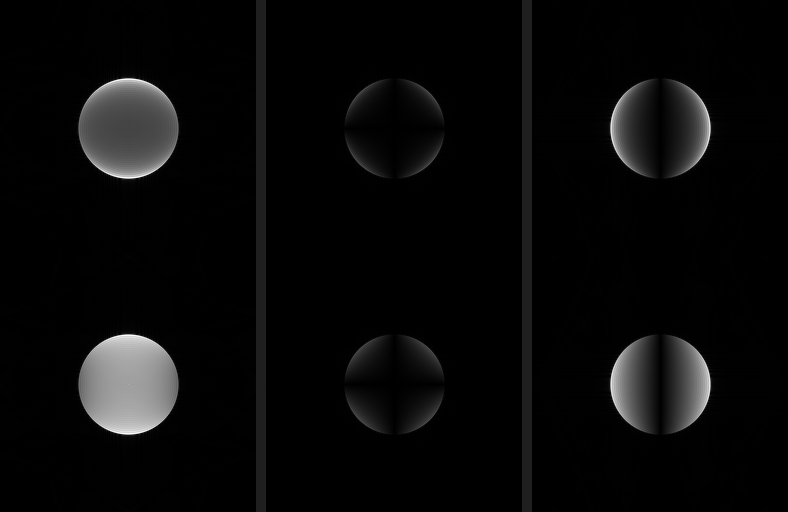

In [184]:
pp_em = PSFParams(0.5, 1.4, 1.52; pol=pol_x)
pa_em = apsf((256,256,1), pp_em; sampling=sampling)

pp_ex = PSFParams(0.5, 1.4, 1.52; pol=pol_x, aplanatic=aplanatic_illumination)
pa_ex = apsf((256,256,1), pp_ex; sampling=sampling)
# size(pa_ex)
show_xyz(ft2d(pa_em), ft2d(pa_ex), gamma=1.0)

Comparison of x-polarized pupils for emission (top) and excitation (bottom). Note the different `aplanatic` factor

# Influence of the Field Vectors on Dipole PSFs  

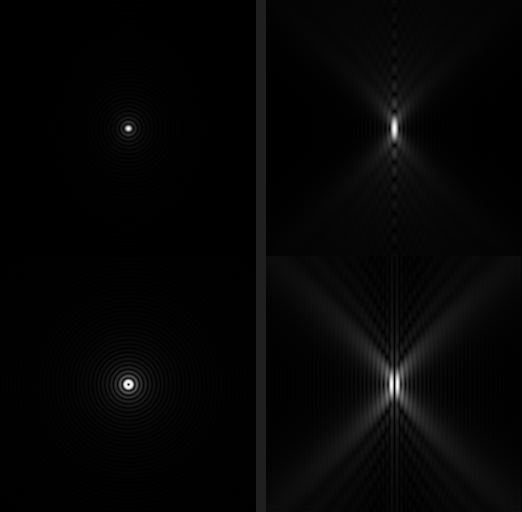

In [154]:
pp = PSFParams(0.5, 1.2, 1.52; pol=pol_circ)
pp1 = PSFParams(pp; transition_dipole=(1.0, 0.0, 0.0)); p1 = psf(sz, pp1; sampling=sampling);
pp3 = PSFParams(pp; transition_dipole=(0.0, 0.0, 1.0)); p3 = psf(sz, pp3; sampling=sampling);
show_xyz(p1,p3; z_offset=0, gamma=0.5) # random/circular polarisation,  dipole X, XZ, Z-oriented

emission dipole (top): parallel and (bottom): perpendicular to optical axis

# Calculation methods

  1.679498 seconds (3.23 k allocations: 1.907 GiB, 11.95% gc time)
  1.979478 seconds (26.15 k allocations: 2.434 GiB, 11.25% gc time)
  2.076502 seconds (12.31 k allocations: 2.628 GiB, 7.87% gc time)
  2.305866 seconds (12.31 k allocations: 2.628 GiB, 18.24% gc time)
  2.082353 seconds (12.31 k allocations: 2.628 GiB, 7.89% gc time)


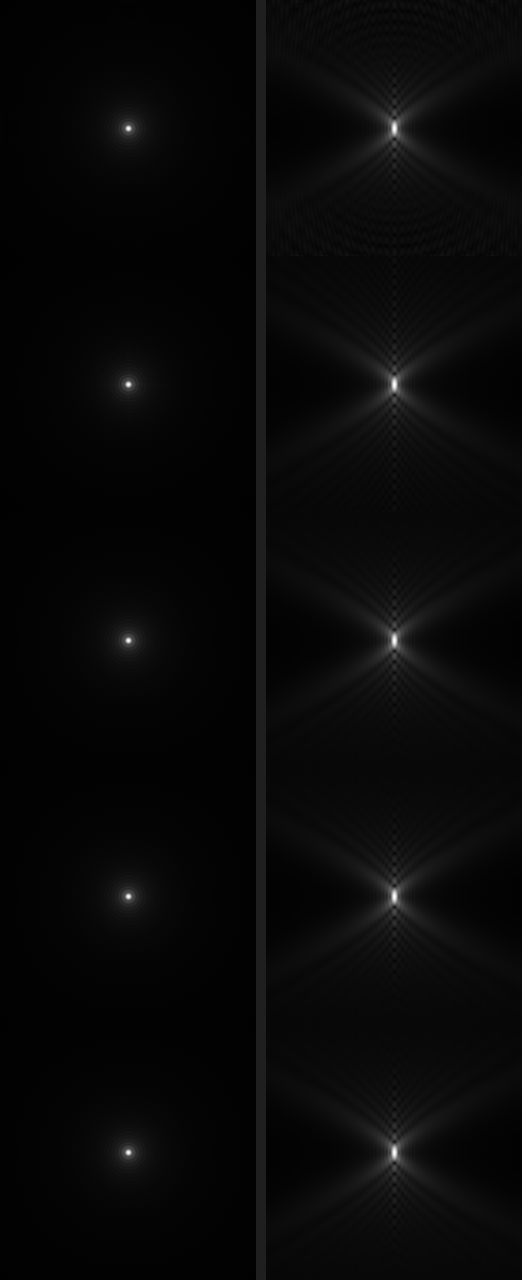

In [155]:
pp1 = PSFParams(λ_em, NA, n; method=MethodPropagate); @time p_slice = psf(sz, pp1; sampling=sampling);
pp2 = PSFParams(λ_em, NA, n; method=MethodRichardsWolf); @time p_RW = psf(sz, pp2; sampling=sampling);
pp3 = PSFParams(λ_em, NA, n; method=MethodPropagateIterative); @time p_iter = psf(sz, pp3; sampling=sampling);
pp4 = PSFParams(λ_em, NA, n; method=MethodShell); @time p_shell = psf(sz, pp3; sampling=sampling);
pp5 = PSFParams(λ_em, NA, n; method=MethodSincR); @time p_sincr = psf(sz, pp3; sampling=sampling);
show_xyz(p_slice, p_RW, p_iter, p_shell, p_sincr)

XY and XZ-views of slice propagation, Richards&Wolf model, iterative slice propagation, shell method, SincR method

# Various Microscopy Modes
+ general PSF parameters: argument of the `PSFParams` structure 
+ mode-specific parameters: `psf` arguments 

  0.287973 seconds (14.24 k allocations: 330.369 MiB, 10.20% gc time)
  0.396259 seconds (15.90 k allocations: 245.714 MiB, 54.07% gc time)
  1.224883 seconds (19.35 k allocations: 1.192 GiB, 55.38% gc time)
  0.569708 seconds (14.25 k allocations: 338.370 MiB, 56.13% gc time)
  1.205191 seconds (29.02 k allocations: 898.021 MiB, 4.26% gc time)


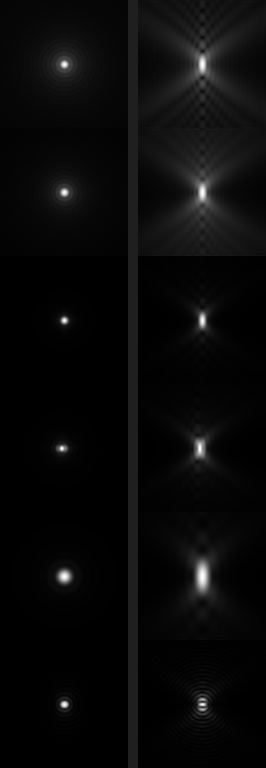

In [158]:
sampling = (0.04,0.04,0.04); sz = (128,128,128)
pp_em = PSFParams(λ_em, NA, n; mode=ModeWidefield); 

p_wf = psf(sz, pp_em; sampling=sampling);
pp_ex = PSFParams(λ_ex, NA, n; mode=ModeWidefield, aplanatic=aplanatic_illumination); 

@time p_wf_ex = psf(sz, pp_ex; sampling=sampling);
pp_ex2p = PSFParams(λ_ex*2, NA, n; mode=ModeWidefield, aplanatic=aplanatic_illumination, pol=pol_x); 

pinhole = 0.5 # in Airy Units
pp_conf = PSFParams(λ_em, NA, n; mode=ModeConfocal); 
@time p_conf = psf(sz, pp_conf; pp_ex=pp_ex, pinhole=pinhole, sampling=sampling);

pp_ism = PSFParams(λ_em, NA, n; mode=ModeISM); 
@time p_ism = psf(sz, pp_ism; pp_ex=pp_ex, sampling=sampling, pinhole_dist=0.12);

pp_2p = PSFParams(λ_ex * 2, NA, n; mode=Mode2Photon, aplanatic=aplanatic_illumination); 
@time p_2p = psf(sz, pp_2p; sampling=sampling);

pp_ex = PSFParams(λ_ex, NA, n; mode=Mode4Pi, aplanatic=aplanatic_illumination, pol=pol_x); 
pp_4pi = PSFParams(λ_em, NA, n; mode=Mode4Pi, pol=pol_x); 
@time p_4pi = psf(sz, pp_ex; pp_em = pp_4pi, pp_em2=pp_4pi,pp_ex2=pp_ex, pinhole=1.0, sampling=sampling, ex2p=false);

show_xyz(p_wf, p_wf_ex, p_conf, p_ism[3], p_2p, p_4pi; gamma=0.4)

XY and XZ views of (top to bottom): Widefield, Scanning Laser excitation, Confocal, ISM, Two-Photon, 4Pi Two-Photon Type A 

# Optical transfer functions
Lets looks at the OTFs:

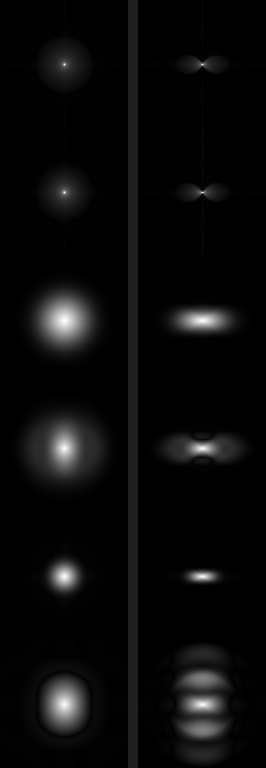

In [159]:
show_xyz(ft(p_wf), ft(p_wf_ex), ft(p_conf), ft(p_ism[3]), ft(p_2p), ft(p_4pi))

## Default Datatype is Float32
Let´s check this:

In [160]:
@show eltype(p_wf)
@show eltype(p_wf_ex)
@show eltype(p_conf)
@show eltype(p_ism[1])
@show eltype(p_2p)
@show eltype(p_4pi);


eltype(p_wf) = Float32
eltype(p_wf_ex) = Float32
eltype(p_conf) = Float32
eltype(p_ism[1]) = Float32
eltype(p_2p) = Float32
eltype(p_4pi) = Float32


# Aberrations
+ based on the package ZernikePolynomials.jl

can be defined independently for excitation / emission, top / bottom 4Pi PSFs.

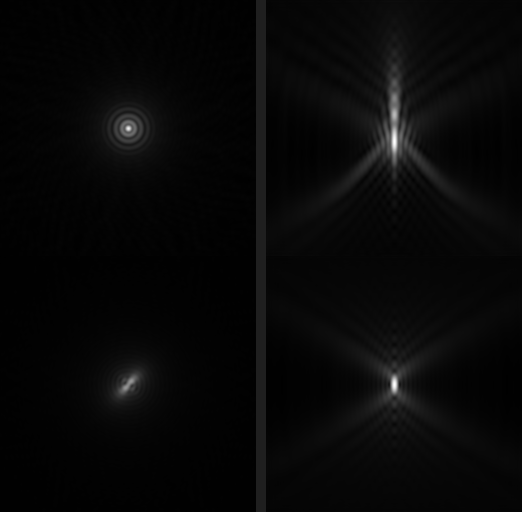

In [161]:
aberr_sp = Aberrations([Zernike_Spherical],[0.2]); sz=(256,256,256)
pp_sp = PSFParams(λ_em, NA, n; method=MethodPropagateIterative, aberrations= aberr_sp)
p_sp = psf(sz, pp_sp; sampling=sampling);

aberr_as = Aberrations([Zernike_ObliqueAstigmatism],[0.1]);
pp_as = PSFParams(λ_em, NA, n; method=MethodPropagateIterative, aberrations= aberr_as)
p_as = psf(sz, pp_as; sampling=sampling);

show_xyz(p_sp, p_as, z_offset=8, gamma=0.5)

Out-of-focus XY and XZ slice of spherical aberration (top) and oblique astigmatism (bottom)

# Julia Implementation Details
+ one general psf function with various `method=` arguments branches to individual PSF calculation routines
+ `psf(::Type{ModeConfocal}, sz::NTuple, ...` is called via `psf(ModeConfocal, sz, ...)`
+ propagations are done via the `rft` goodies in the FourierTools toolbox
+ pinholes and pupils were implemented using the `jinc`/`sinc`-trick (i.e. generating the FT rather than the function)
+ pinholes can be square-shaped
+ the `ZernikePolynomial.jl` was helpful

# Advantages of Julia
+ Julia's speet really pays off
+ Julia's dispatch mechanism is great!
+ Julia's non-existing `squeeze` function is a blessing!
## Branches are defined as a struct hierarchy (waiting for Julia/VSCode support of child-class parameter selection)

In [ ]:
abstract type PSFMode end
struct ModeWidefield <: PSFMode end
struct ModeConfocal <: PSFMode end
struct ModeISM <: PSFMode end
struct Mode2Photon <: PSFMode end
struct Mode4Pi <: PSFMode end
struct ModeSTED <: PSFMode end

abstract type PSFMethod end
struct MethodSincR <: PSFMethod end
struct MethodPropagate <: PSFMethod end
struct MethodPropagateIterative<: PSFMethod end
struct MethodRichardsWolf <: PSFMethod end
struct MethodShell <: PSFMethod end
struct MethodParaxial <: PSFMethod end

# Zoom Trick
The required sampling depends on
+ whether you calculate an `apsf` or an intensity `psf`
+ whether you calculate in `ModeWidefield` or `ModeConfocal`
+ Fourier-upsampling (`FourierTools.upsample2`) is quicker than calculation with higher sampling

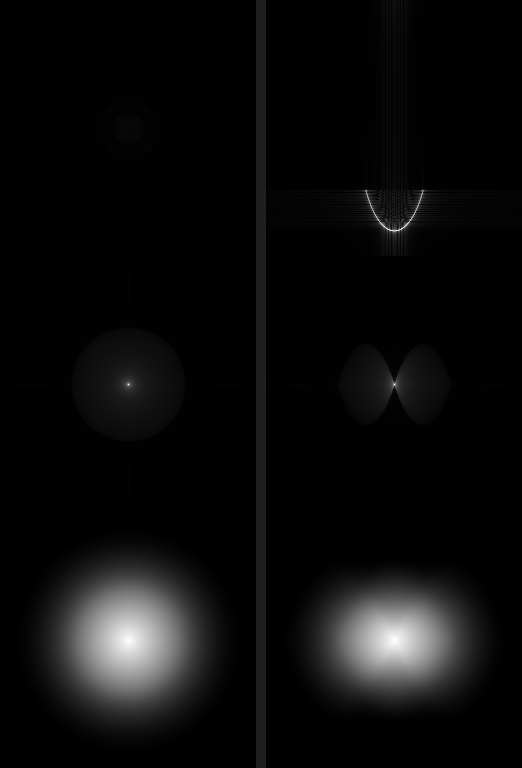

In [186]:
sampling = (0.07, 0.07, 0.2); sz = (256,256,256)
pp =PSFParams(λ_em, 0.8, 1.0; method=MethodRichardsWolf, pol=pol_scalar)
a_wf = apsf(sz, pp; sampling=sampling);
p_wf = psf(sz, pp; sampling=sampling);
pp_em =PSFParams(λ_em, 0.8, 1.0; mode=ModeConfocal, method=MethodPropagateIterative, pol=pol_scalar)
pp_ex =PSFParams(λ_ex, 0.8, 1.0; method=MethodPropagateIterative, pol=pol_scalar)
p_conf = psf(sz, pp_em; pp_ex=pp_ex, pinhole=0.1, sampling=sampling);
show_xyz(ft(a_wf), ft(p_wf), ft(p_conf), gamma=0.6)


Note how the amplitude OTF the McCutchen pupil (top), the widefield OTF (middle) and the confocal OTF (bottom) need succesively more space.

## The resampling trick can be disabled

  1.758768 seconds (14.23 k allocations: 1.436 GiB, 19.07% gc time)
  8.139154 seconds (45.86 k allocations: 5.000 GiB, 4.06% gc time)


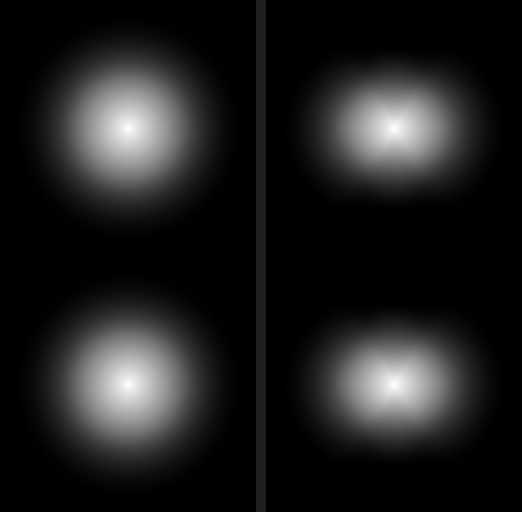

In [187]:
@time p_conf_sub = psf(sz, pp_em; pp_ex=pp_ex, pinhole=0.1, sampling=sampling);
@time p_conf_no_sub = psf(sz, pp_em; pp_ex=pp_ex, pinhole=0.1, sampling=sampling,  use_resampling=false);
show_xyz(ft(p_conf_sub), ft(p_conf_no_sub), gamma=0.6)

# The Widefield Z-undersampling problem
How about Z-sampling of a WF amplitude PSF?

Solution to be able to apply the subsampling trick: center Fourier-shell on creation, resample, apply phase-ramp 

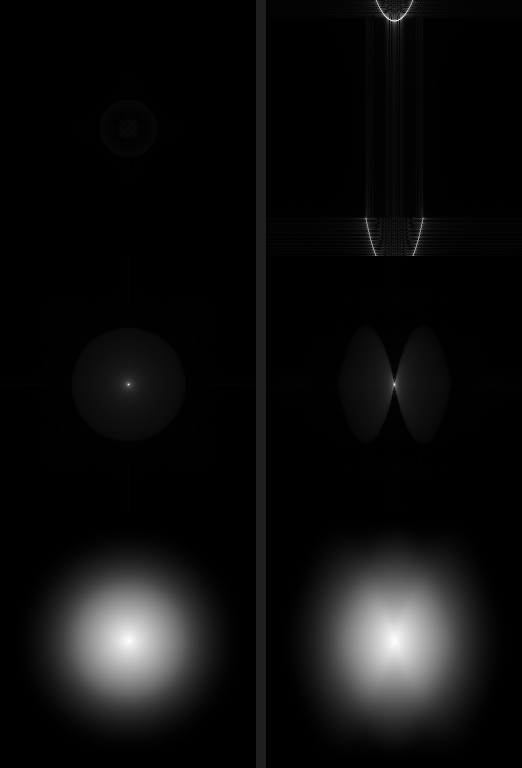

In [188]:
sampling = (0.07, 0.07, 0.29); sz = (256,256,256)
pp =PSFParams(λ_em, 0.8, 1.0; method=MethodRichardsWolf, pol=pol_scalar)
a_wf = apsf(sz, pp; sampling=sampling);
p_wf = psf(sz, pp; sampling=sampling);
pp_em =PSFParams(λ_em, 0.8, 1.0; mode=ModeConfocal, method=MethodPropagateIterative, pol=pol_scalar)
pp_ex =PSFParams(λ_ex, 0.8, 1.0; method=MethodPropagateIterative, pol=pol_scalar)
p_conf = psf(sz, pp_em; pp_ex=pp_ex, pinhole=0.1, sampling=sampling);
show_xyz(ft(a_wf), ft(p_wf), ft(p_conf), gamma=0.6)

Note that the amplitude is ALIASED along k_z

But this is OK as long as the intensity is calculated!

# Outlook
+ use `Unitful`
+ implement the mirror trick for further speed improvement
+ implement a CZT method (pupil covers full range and CZT zooms in)
+ implement aberrations in Richards & Wolf method
+ implement more `mode`s such as `ModeUZI`, `ModeSTED`, `Mode3Photon`
+ optionally account for the pixel form factor (i.e. multiply OTF by `sinc`)